# Deliverable #4

The fourth deliverable (skips three as it isn't a coding deliverable). This deliverable is more like a supplementary to the [Deliverable #2](../D2/README.md); implementing three new neural network architectures.

This `index` file serves as the testing ground for the flow that will later be used by the separate notebooks when fine tuning them.

All other notebooks are:
- [VGG16](vgg16.ipynb) - VGG16
- [IV3](iv3.ipynb) - InceptionV3
- [RN50](rn50.ipynb) - Resnet50

**Instructions**

Download the CIFAR-10 dataset from a reliable dataset repository such as TensorFlow Datasets or directly from the official source. The CIFAR-10 dataset contains 60,000 color images sized at 32x32 pixels, categorized into 10 classes with 6,000 images per class. It is divided into 50,000 training images and 10,000 test images. The training set is further split into five batches, each containing 10,000 images, while the test batch contains 1,000 randomly selected images from each class. The training batches include the remaining images in random order, and although each class has 5,000 training samples in total, individual batches may have varying distributions.

For this task, you are required to implement and fine-tune three well-known deep convolutional neural network architectures: **VGG16**, **InceptionV3**, and **ResNet50**. Use transfer learning techniques by loading pretrained weights (e.g., from ImageNet), adjusting the input size if necessary, and appending appropriate classification layers for the 10-class output of CIFAR-10. Train each model on the CIFAR-10 training set and evaluate on the test set. You should also explore and apply regularization techniques such as dropout, batch normalization, and weight decay to improve performance and avoid overfitting.

Present the performance of each model using both visual and quantitative methods. This includes plotting the training and validation accuracy and loss across epochs using the model history, and evaluating classification performance with a confusion matrix. Your analysis should compare how the three models performed, highlighting differences in accuracy, generalization, and training time.

Finally, write a report summarizing your findings and classification results. The report should include an overview of each architecture, your implementation approach, the regularization techniques applied, and the evaluation results. Save the report as a PDF file named D4_LastName.pdf. Additionally, submit a ZIP file named D4_LastName.zip containing your complete code (notebooks or scripts), model files if any, and any helper assets used in the project.

## Imports

All needed libraries will be imported here.

Unless conditional, all imports must be done in this section to prevent workspace cluttering. Imports are sorted in an ascending manner, starting from "a" to "Z".

In [1]:

from copy import copy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import plot_model
import datetime
import gc
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import tensorflow as tf

%matplotlib inline

## Data and Variable

Sets all the global data and variables here.

Global variables will be defined and instantiated in this section, preventing a confusing clutter down the line and allowing readability when revisions are needed.

### Instantiations

Instantiations of variables will be done here, preventing mixture of variable preview and definition.

In [2]:

data = {
    "train": {
        "raw": [os.path.join('data', file) for file in os.listdir("data") if file.startswith('data_batch_')],
        "loaded": {},
        "processed": None
    },
    "test": {
        "raw": os.path.join('data', 'test_batch'),
        "loaded": {},
        "processed": None
    },
    "meta": os.path.join('data', 'batches.meta')
}
"""
A dictionary to hold the data for the CIFAR-10 dataset.
The dictionary contains the following keys:

- train: A dictionary containing the training data. It has two keys:
    - raw: A list of file paths for the training data files.
    - loaded: A dictionary to hold the loaded training data.
    - processed: A dictionary to hold the processed training data.
- test: A dictionary containing the test data. It has two keys:
    - raw: The file path for the test data file.
    - loaded: A dictionary to hold the loaded test data.
    - processed: A dictionary to hold the processed test data.
- meta: The file path for the metadata file.

:var data: dict
"""

models = {
    "aliases": {
        VGG16.__name__: "VGG16",
        InceptionV3.__name__: "IV3",
        ResNet50.__name__: "RN50",
	},
    "configs": {
        "VGG16": [],
		"IV3": [],
		"RN50": [],
	},
    "fitted": {
        "VGG16": [],
		"IV3": [],
		"RN50": [],
	},
    "predictionResults": {
        "VGG16": [],
		"IV3": [],
		"RN50": [],
	}
}
"""
A dictionary to hold the compiled and fitted models for transfer learning.
The dictionary contains the following subkeys:

- VGG16: The VGG16 model from Keras applications.
- IV3: The InceptionV3 model from Keras applications.
- RN50: The ResNet50 model from Keras applications.

... for keys:

- configs: A list to hold the model configurations.
- fitted: A list to hold the fitted models.
- predictionResults: A list to hold the prediction results.

For reference; the `aliases` object is used to map the model names to their respective
aliases for the three other 1st level keys. By simply using the model name (`model.__name__`),
the model can be referenced in the other keys.

Example:
```
alias = models["aliases"][model.__name__]
model = models["configs"][alias][0]
```
"""

callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        verbose = 2,
        restore_best_weights = True
    ),
    # ReduceLROnPlateau(
    #     monitor = 'val_loss',
    #     factor = 0.5,
    #     patience = 5,
    #     verbose = 2,
    #     min_lr = 1e-6
    # )
]
"""
A list of callbacks for the model training. Currently, it contains
the following callbacks:
- EarlyStopping: Stops training when a monitored metric has stopped improving.
"""

configCombinations = {
	'baseModel': [VGG16, InceptionV3, ResNet50],
	'trainBase': [True, False],
	'poolingLayer': [GlobalAveragePooling2D, Flatten],
	'dropoutRate': [0.3, 0.4, 0.5],
	'denseUnits': [512, 640, 768, 896],
	'useBatchNorm': [True, False],
	'hlDecayMode': ['l1', 'l2', 'l1_l2'],
	'hlDecayRate': [0.0001, 0.0005, 0.001],
	'opDecayMode': ['l1', 'l2', 'l1_l2'],
	'opDecayRate': [0.0001, 0.0005, 0.001],
}
"""
A dictionary that holds all possible configuration combination values for `buildModel()`
function.
"""

modelProfiler = []
"""
An empty list that will be used to store the training time of each model.
"""

None

#### Functions

In [3]:

def unpickle(file):
    """
    Decompiles a pickle file.

    :param file: Path to the pickle file.
    :type file: str
    
    :return: The unpickled data.
    :rtype: dict
    """
    if not os.path.isfile(file):
        raise FileNotFoundError(f"File {file} not found.")
    
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

def unpickleToTuple(file):
    """
    Decompiles a pickle file into a tuple. The tuple
    contains the `data` and `labels` keys from the unpickled data
    in that respective order.

    The `data` key contains the image data and the `labels` key
    contains the labels for the images.

    The `data` key is a numpy array of shape (n, 3072) where n is the
    number of images. The `labels` key is a list of length n containing
    the labels for the images.

    :param file: Path to the pickle file.
    :type file: str
    
    :return: The unpickled data as a tuple.
    :rtype: tuple
    """
    data = unpickle(file)
    return (data[b'data'], data[b'labels'])

def showImg(input, title = None, axis = False):
    """
    Displays an image.

    :param input: The image to display.
    :type input: numpy.ndarray
    
    :param title: Title of the image.
    :type title: str

    :param axis: Whether to show the axis or not.
    :type axis: bool
    """
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    if not axis:
        plt.axis('off')
    plt.show()

def buildModel(baseModel, trainBase = False, poolingLayer = GlobalAveragePooling2D, dropoutRate = 0.5, denseUnits = 512, useBatchNorm = True, hlDecayMode = 'l2', hlDecayRate = 0.001, opDecayMode = 'l2', opDecayRate = 0.001) -> Model:
	"""
	Builds the model for transfer learning.

	:param baseModel: The base model to use for transfer learning. Required.
	:type baseModel: tensorflow.keras.applications.VGG16 | tensorflow.keras.applications.InceptionV3 | tensorflow.keras.applications.ResNet50

	:param trainBase: Whether to train the base model or not. Default is False.
	:type trainBase: bool

	:param dropoutRate: The dropout rate for the model. Default is 0.5.
	:type dropoutRate: float

	:param denseUnits: The number of units in the dense layer. Default is 512.
	:type denseUnits: int

	:param useBatchNorm: Whether to use batch normalization or not. Default is True.
	:type useBatchNorm: bool

	:hlDecayMode: The decay mode for the hidden layer. Default is 'l2'.
	:type hlDecayMode: 'l1', 'l2', 'l1_l2', 'none'

	:hlDecayRate: The decay rate for the hidden layer. Default is 0.001.
	:type hlDecayRate: float

	:opDecayMode: The decay mode for the output layer. Default is 'l2'.
	:type opDecayMode: 'l1', 'l2', 'l1_l2', 'none'

	:opDecayRate: The decay rate for the output layer. Default is 0.001.
	:type opDecayRate: float

	:return: The built model.
	:rtype: tensorflow.keras.models.Model
	"""
	# Guard check just to make sure the pooling layer won't kill my device...
	# Basically, it ensures that 'Flatten' is not used with models other than VGG16
	if poolingLayer is Flatten and baseModel is not VGG16:
		poolingLayer = GlobalAveragePooling2D

	# Applies the resizing layer to the input shape
	targetShape = (299, 299) if baseModel is InceptionV3 else (224, 224)
	inputTensor = Input(shape = (32, 32, 3))
	inputTensor = Resizing(*targetShape)(inputTensor)
	print("Resizing Layer Shape: ", inputTensor.shape)

	base = baseModel(weights = 'imagenet', include_top = False, input_tensor = inputTensor)
	print(f"Base model: {baseModel.__name__} - {base.output}")

	# Freeze the base model layers (if True)
	base.trainable = trainBase

	x = poolingLayer()(base.output)
	print(f"Pooling Layer Shape: {x.shape}")

	if useBatchNorm:
		x = BatchNormalization()(x)

	# HIDDEN LAYER
	# By default, this looks like without the decays:
	#	x = Dense(512, activation = "relu")(x)
	hlKernelRegularizer = None
	if hlDecayMode in ('l1', 'l2', 'l1_l2') and hlDecayRate > 0:
		if hlDecayMode == 'l1':
			hlKernelRegularizer = l1(hlDecayRate)
		elif hlDecayMode == 'l2':
			hlKernelRegularizer = l2(hlDecayRate)
		elif hlDecayMode == 'l1_l2':
			if hlDecayRate is list:
				hlKernelRegularizer = l1_l2(hlDecayRate[0], hlDecayRate[1])
			else:
				hlKernelRegularizer = l1_l2(hlDecayRate, hlDecayRate)
	x = Dense(denseUnits, activation = "relu", kernel_regularizer = hlKernelRegularizer)(x)

	if useBatchNorm:
		x = BatchNormalization()(x)

	if dropoutRate > 0:
		# By default, this looks like:
		#	x = Dropout(0.5)(x)
		x = Dropout(dropoutRate)(x)

	# OUTPUT LAYER
	# By default, this looks like without the decays:
	#	x = Dense(10, activation = "softmax")(x)
	opKernelRegularizer = None
	if opDecayMode in ('l1', 'l2', 'l1_l2') and opDecayRate > 0:
		if opDecayMode == 'l1':
			opKernelRegularizer = l1(opDecayRate)
		elif opDecayMode == 'l2':
			opKernelRegularizer = l2(opDecayRate)
		elif opDecayMode == 'l1_l2':
			if opDecayRate is list:
				opKernelRegularizer = l1_l2(opDecayRate[0], opDecayRate[1])
			else:
				opKernelRegularizer = l1_l2(opDecayRate, opDecayRate)
	outputs = Dense(10, activation = "relu", kernel_regularizer = opKernelRegularizer)(x)

	return Model(inputs = inputTensor, outputs = outputs)

def randomConfigSampler(possibleConfigValues, nSamples):
	"""
	Samples random configurations from the possible configuration values. The function is
	designed to generate a list of unique configurations, allowing for creating a diverse set of
	models for experimentation.

	:param popssibleConfigValues: The possible configuration values.
	:type popssibleConfigValues: dict

	:param nSamples: The number of samples to generate.
	:type nSamples: int

	:return: A list of random configurations.
	:rtype: list
	"""
	configs = []
	definedConfigs = set()

	while len(configs) < nSamples:
		config = {}
 
		# Sample a random configuration
		for key, value in possibleConfigValues.items():
			config[key] = random.choice(value)

			if key == 'poolingLayer':
				# Additional guard check just to make sure the pooling layer won't kill my device...
				# Basically, it ensures that 'Flatten' is not used with models other than VGG16
				if config[key] is Flatten and config['baseModel'] is not VGG16:
					config[key] = GlobalAveragePooling2D

		# Creates the input shape based on the base model
		# target_shape = (299, 299) if config['baseModel'] is InceptionV3 else (224, 224)
		# config['inputTensor'] = Input(shape = (*target_shape, 3))

		configTuple = tuple(sorted((k, v) for k, v in config.items() if k != 'inputTensor'))

		# Add the config to the list if unique
		if configTuple not in definedConfigs:
			definedConfigs.add(configTuple)
			configs.append(config)
		# If the config is not unique, try again
		else:
			continue

	return configs

def preprocessImg(img, lbl, targetSize, augment = False):
	"""
	Preprocesses the image and label for training.

	:param img: The image to preprocess.
	:type img: numpy.ndarray

	:param lbl: The label to preprocess.
	:type lbl: int

	:param targetSize: The target size for the image.
	:type targetSize: tuple

	:param augment: Whether to augment the image or not. Default is False.
	:type augment: bool

	:return: The preprocessed image and label.
	:rtype: tuple
	"""
	img = tf.reshape(img, (32, 32, 3))
	img = tf.image.resize(img, targetSize)
	img = tf.cast(img, tf.float32) / 255.0	

	if augment:
		img = tf.image.random_flip_left_right(img)
		img = tf.image.random_brightness(img, 0.2)
		img = tf.image.random_contrast(img, 0.8, 1.2)
		img = tf.image.random_saturation(img, 0.8, 1.2)
		img = tf.image.random_hue(img, 0.08)

	return img, lbl

def makeDataset(x, y, targetSize, augment = False, batchSize = 15):
	"""
	Creates a TensorFlow dataset from the given data.

	:param x: The input data.
	:type x: numpy.ndarray

	:param y: The labels.
	:type y: numpy.ndarray

	:param targetSize: The target size for the images.
	:type targetSize: tuple

	:param augment: Whether to augment the images or not. Default is False.
	:type augment: bool

	:param batchSize: The batch size for the dataset. Default is 15.
	:type batchSize: int
	"""
	ds = tf.data.Dataset.from_tensor_slices((x, y))
	ds = ds.map(lambda img, label: preprocessImg(img, label, targetSize, augment),
            num_parallel_calls=tf.data.AUTOTUNE)
	if augment:
		ds = ds.shuffle(10000)
	ds = ds.batch(batchSize).prefetch(tf.data.AUTOTUNE)

	return ds

def getMetrics(model, dataset, logPerBatch = False):
	"""
	Calculates the accuracy `(avg)` and accuracy range `(min, max)`
	for the given model and dataset.

	Also returns the true labels and predicted labels. The metrics are all floats
	that represent the score in decimal and not percentage.

	:param model: The model to use for prediction.
	:type model: tensorflow.keras.models.Model

	:param dataset: The dataset to calculate the metrics for.
	:type dataset: tensorflow.data.Dataset

	:param logPerBatch: Whether to log the metrics per batch or not. Default is False.
	:type logPerBatch: bool

	:return: A tuple containing metrics, the true labels, and the predicted labels; wherein the metrics is also a tuple containing the `(avg, min, max)` values.
	:rtype: tuple(tuple, list, list)
	"""
	min = 0
	max = 0
	avg = 0

	yTrue = []
	yPred = []

	for x, y in dataset:
		classes = model.predict(x, verbose = 0)
		classes = np.argmax(classes, axis = 1)

		yTrue.extend(y)
		yPred.extend(classes)

		if logPerBatch:
			print(f"Classes: {classes}")
			print(f"Labels: {y}")

		# Accuracy
		accuracy = np.sum(classes == y) / len(y)
		if accuracy > max:
			max = accuracy
		if accuracy < min or min == 0:
			min = accuracy
		avg += accuracy

		if logPerBatch:
			print(f"Formula: {np.sum(classes == y)} / {len(y)}")
			print(f"Accuracy: {accuracy * 100:.2f}%")
			print(f"Of {len(y)} images, {np.sum(classes == y)} were correct while {np.sum(classes != y)} were incorrect.")

	avg /= len(dataset)
	return (avg, min, max), yTrue, yPred

def plotModelHistory(modelName, history, accuracy, yTrue, yPred):
	"""
	Plots the training history of the model.

	:param modelName: The name of the model.
	:type modelName: str

	:param history: The training history of the model.
	:type history: tensorflow.keras.callbacks.History

	:param accuracy: The accuracy of the model in decimal form (not percentage).
	:type accuracy: float

	:param yTrue: The true labels of the dataset.
	:type yTrue: list

	:param yPred: The predicted labels of the dataset.
	:type yPred: list
	"""
	status = "Underfitted" if accuracy < 0.5 else "Overfitted" if accuracy > 0.9 else "Just Right"
	yTrue = np.sum(np.array(yTrue) == np.array(yPred))
	yLength = len(yPred)
	yScore = yTrue / yLength

	accuracy = accuracy * 100
	unixTime = int(datetime.datetime.now().timestamp() * 1e6)

	print(f"Accuracy: {accuracy:.2f}%")
	print(f"Using `forCM`: {yTrue} / {yLength} = {yScore * 100:.2f}%")

	if not os.path.exists(f"outputs/accuracy/{modelName}"):
		os.makedirs(f"outputs/accuracy/{modelName}")

	plt.figure(figsize = (10, 6))
	plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
	plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
	plt.legend()
	plt.grid()
	plt.title(f'Accuracy ({modelName})\nStatus: {status} ({accuracy:.2f}%)')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.savefig(f"outputs/accuracy/{modelName}/{unixTime} - {accuracy:.2f}%.png")

def plotConfusionMatrix(yTrue, yPred, modelName, accuracy):
	"""
	Plots the confusion matrix for the model predictions.

	:param yTrue: The true labels of the dataset.
	:type yTrue: list

	:param yPred: The predicted labels of the dataset.
	:type yPred: list

	:param modelName: The name of the model.
	:type modelName: str

	:param accuracy: The accuracy of the model in decimal form (not percentage).
	:type accuracy: float
	"""
	unixTime = int(datetime.datetime.now().timestamp() * 1e6)
	confusion = confusion_matrix(yTrue, yPred)

	plt.figure(figsize = (10, 8))
	sns.heatmap(confusion, annot = True, fmt = 'd', cmap = 'Blues')

	plt.title('Confusion Matrix')
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')

	if not os.path.exists(f"outputs/confusion_matrix/{modelName}"):
		os.makedirs(f"outputs/confusion_matrix/{modelName}")

	plt.savefig(f"outputs/confusion_matrix/{modelName}/{unixTime} - {accuracy:.2f}%.png")

def plotModel(model, accuracy, modelName = None):
	"""
	Plots the model architecture.

	:param model: The model to plot.
	:type model: tensorflow.keras.models.Model

	:param accuracy: The accuracy of the model in decimal form (not percentage).
	:type accuracy: float

	:param modelName: The name of the model. Optional.
	:type modelName: str
	"""
	if modelName is None:
		modelName = model.__name__

	unixTime = int(datetime.datetime.now().timestamp() * 1e6)
	plot_model(model, to_file = f"outputs/{modelName}_model_{unixTime} - {accuracy}%.png", show_shapes = True, show_layer_names = True)

None

### Previews

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
randomConfigSampler(configCombinations, 10)

[{'baseModel': <function keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
  'trainBase': False,
  'poolingLayer': keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D,
  'dropoutRate': 0.5,
  'denseUnits': 768,
  'useBatchNorm': False,
  'hlDecayMode': 'l1',
  'hlDecayRate': 0.0001,
  'opDecayMode': 'l2',
  'opDecayRate': 0.001},
 {'baseModel': <function keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
  'trainBase': True,
  'poolingLayer': keras.layers.reshaping.flatten.Flatten,
  'dropoutRate': 0.3,
  'denseUnits': 640,
  'useBatchNorm': True,
  'hlDecayMode': 'l1',
  'hlDecayRate': 0.0005,
  'opDecayMode': 'l1_l2',
  'opDecayRate': 0.001},
 {'baseModel': <function keras.applications.inception_v3.InceptionV3(include_top=True, weight

In [6]:
print(f"Training data files: {data['train']['raw']}")
print(f"Testing data file: {data['test']['raw']}")
print(f"Meta data file: {data['meta']}")

Training data files: ['data\\data_batch_1', 'data\\data_batch_2', 'data\\data_batch_3', 'data\\data_batch_4', 'data\\data_batch_5']
Testing data file: data\test_batch
Meta data file: data\batches.meta


In [7]:
for file in data['train']["raw"]:
    print(f"Unpickling {file}...")
    batch = unpickle(file)
    print(f"Unpickled {file} with keys: {batch.keys()}")
    print(f"Batch shape: {batch[b'data'].shape}")
    print(f"Labels shape: {len(batch[b'labels'])}")
    print(f"Batch size: {len(batch[b'data'])}")
    print(f"Batch content size: {len(batch[b'data'][random.randint(0, len(batch[b'data']) - 1)])}")
    print(f"Peek in the batch: {batch[b'data']}")
    print(f"Peek in the batch content: {batch[b'data'][random.randint(0, len(batch[b'data']) - 1)]}")
    print("==============================================")
    data['train']["loaded"][file] = batch

Unpickling data\data_batch_1...
Unpickled data\data_batch_1 with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Batch shape: (10000, 3072)
Labels shape: 10000
Batch size: 10000
Batch content size: 3072
Peek in the batch: [[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]
Peek in the batch content: [87 83 83 ... 42 42 44]
Unpickling data\data_batch_2...
Unpickled data\data_batch_2 with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Batch shape: (10000, 3072)
Labels shape: 10000
Batch size: 10000
Batch content size: 3072
Peek in the batch: [[ 35  27  25 ... 169 168 168]
 [ 20  20  18 ... 111  97  51]
 [116 115 155 ...  18  84 124]
 ...
 [127 139 155 ... 197 192 191]
 [190 200 208 ... 163 182 192]
 [177 174 182 ... 119 127 136]]
Peek in the batch content: [68 65 60 ... 36 33 35]
Unpickling data\data_batch_3..

In [8]:
print(f"Unpickling {data['test']['raw']}...")
batch = unpickle(data['test']['raw'])
print(f"Unpickled {data['test']['raw']} with keys: {batch.keys()}")
print(f"Batch shape: {batch[b'data'].shape}")
print(f"Labels shape: {len(batch[b'labels'])}")
print(f"Batch size: {len(batch[b'data'])}")
print(f"Batch content size: {len(batch[b'data'][random.randint(0, len(batch[b'data']) - 1)])}")
print(f"Peek in the batch: {batch[b'data']}")
print(f"Peek in the batch content: {batch[b'data'][random.randint(0, len(batch[b'data']) - 1)]}")
print("==============================================")
data['test']["loaded"] = batch

Unpickling data\test_batch...
Unpickled data\test_batch with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Batch shape: (10000, 3072)
Labels shape: 10000
Batch size: 10000
Batch content size: 3072
Peek in the batch: [[158 159 165 ... 124 129 110]
 [235 231 232 ... 178 191 199]
 [158 158 139 ...   8   3   7]
 ...
 [ 20  19  15 ...  50  53  47]
 [ 25  15  23 ...  80  81  80]
 [ 73  98  99 ...  94  58  26]]
Peek in the batch content: [ 75  80  66 ... 255 255 255]


In [9]:
data['meta'] = unpickle(data['meta'])
data['meta']

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [10]:
data['train']['loaded'][f'data\\data_batch_{random.randint(1, 5)}']

{b'batch_label': b'training batch 2 of 5',
 b'labels': [1,
  6,
  6,
  8,
  8,
  3,
  4,
  6,
  0,
  6,
  0,
  3,
  6,
  6,
  5,
  4,
  8,
  3,
  2,
  6,
  0,
  3,
  1,
  4,
  0,
  6,
  6,
  2,
  7,
  6,
  9,
  0,
  4,
  5,
  7,
  1,
  6,
  7,
  9,
  1,
  7,
  7,
  8,
  0,
  3,
  7,
  4,
  7,
  3,
  1,
  0,
  4,
  6,
  6,
  1,
  4,
  9,
  2,
  6,
  4,
  5,
  0,
  4,
  6,
  0,
  8,
  3,
  4,
  8,
  8,
  3,
  9,
  5,
  7,
  1,
  9,
  4,
  7,
  9,
  1,
  9,
  7,
  5,
  2,
  7,
  3,
  4,
  8,
  8,
  2,
  1,
  5,
  9,
  2,
  7,
  8,
  8,
  6,
  8,
  8,
  1,
  3,
  8,
  8,
  5,
  4,
  7,
  1,
  6,
  6,
  1,
  6,
  1,
  6,
  7,
  0,
  4,
  6,
  9,
  5,
  8,
  7,
  1,
  9,
  0,
  3,
  3,
  7,
  6,
  9,
  0,
  4,
  7,
  1,
  4,
  3,
  4,
  3,
  9,
  8,
  7,
  0,
  8,
  3,
  9,
  1,
  0,
  8,
  0,
  9,
  4,
  0,
  2,
  1,
  4,
  2,
  7,
  1,
  7,
  0,
  2,
  9,
  7,
  9,
  8,
  6,
  4,
  4,
  1,
  1,
  7,
  8,
  8,
  6,
  4,
  5,
  6,
  3,
  9,
  4,
  2,
  5,
  3,
  6,
  7,
  7,
  3,
  9,
  1,
 

In [11]:
data['meta'][b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

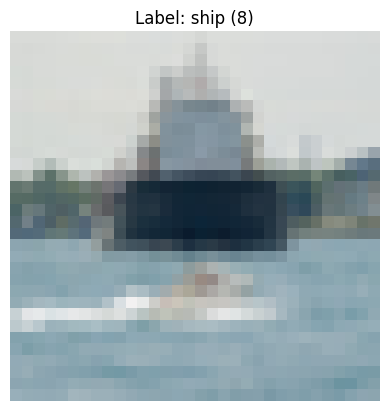

In [12]:
target = data['train']['loaded'][f'data\\data_batch_{random.randint(1, 5)}']
targetIndex = random.randint(0, len(target[b'data']) - 1)
label = target[b'labels'][targetIndex]
label = f"{data['meta'][b'label_names'][label].decode('UTF-8')} ({label})"

showImg(
    target[b'data'][targetIndex].reshape(3, 32, 32).transpose(1, 2, 0),
    f"Label: {label}",
)

In [13]:
data['test']['loaded'][b'data']

array([[158, 159, 165, ..., 124, 129, 110],
       [235, 231, 232, ..., 178, 191, 199],
       [158, 158, 139, ...,   8,   3,   7],
       ...,
       [ 20,  19,  15, ...,  50,  53,  47],
       [ 25,  15,  23, ...,  80,  81,  80],
       [ 73,  98,  99, ...,  94,  58,  26]], dtype=uint8)

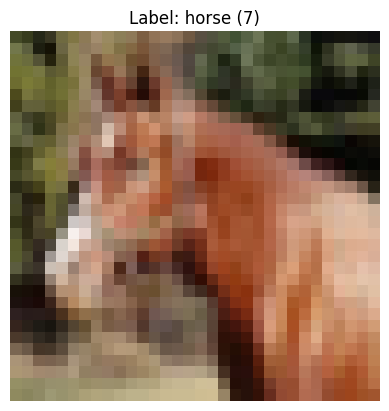

In [14]:
target = data['test']['loaded']
targetIndex = random.randint(0, len(target[b'data']) - 1)
label = target[b'labels'][targetIndex]
label = f"{data['meta'][b'label_names'][label].decode('UTF-8')} ({label})"

showImg(
    data['test']['loaded'][b'data'][targetIndex].reshape(3, 32, 32).transpose(1, 2, 0),
    f"Label: {label}"
)

## Process

Here begins the process which includes data splitting and pre-processing.

### Splitting the Data

In [15]:
# Not applicable for this dataset... It'll be handled in the Pre-Processing step

### Pre Processing

In [16]:
data['train']['processed'] = {
    'combined': {
        'data': None,
        'labels': None,
        'generators': {
			224: None,
			299: None
		}
    },
    'validation': {
        'data': None,
        'labels': None,
        'generators': {
			224: None,
			299: None
		}
    },
}

data['test']['processed'] = {
    'generators': {
		224: None,
		299: None
	}
}

# Splitting the data into training and validation sets
x = []
y = []
for file in data['train']['loaded']:
    x.append(data['train']['loaded'][file][b'data'])
    y.append(data['train']['loaded'][file][b'labels'])
x_train, x_val, y_train, y_val = train_test_split(
    np.concatenate(x),
    np.concatenate(y),
    test_size = 0.2
)

# Reshaping the data to match the input shape of the model - THIS IS SO STUPID
for targetShape in [224, 299]:
	targetSize = (targetShape, targetShape)
    
	#######################
	### VALIDATION DATA ###
	#######################
	data['train']['processed']['validation']['data'] = x_val
	data['train']['processed']['validation']['labels'] = y_val
	data['train']['processed']['validation']['generators'][targetShape] = makeDataset(
		data['train']['processed']['validation']['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
		data['train']['processed']['validation']['labels'],
		targetSize
	)
 
	# data['train']['processed']['validation']['generators'][targetShape] = (ImageDataGenerator(
	# 	rescale = 1./255,
	# )).flow(
    #  	resize(
	# 		data['train']['processed']['validation']['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
	# 		targetSize
	# 	).numpy(),
	# 	data['train']['processed']['validation']['labels'],
	# )

	##################
	### TRAIN DATA ###
	##################
	data['train']['processed']['combined']['data'] = x_train
	data['train']['processed']['combined']['labels'] = y_train
	data['train']['processed']['combined']['generators'][targetShape] = makeDataset(
		data['train']['processed']['combined']['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
		data['train']['processed']['combined']['labels'],
		targetSize,
		True
	)

	# data['train']['processed']['combined']['generators'][targetShape] = (ImageDataGenerator(
	# 	rescale = 1./255,
	# 	rotation_range = 20,
	# 	width_shift_range = 0.2,
	# 	height_shift_range = 0.2,
	# 	shear_range = 0.2,
	# 	zoom_range = 0.2,
	# 	horizontal_flip = True
	# )).flow(
	# 	resize(
	# 		data['train']['processed']['combined']['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
	# 		targetSize
	# 	).numpy(),
	# 	data['train']['processed']['combined']['labels'],
	# )

	### -------------
	###
	### -------------

	#################
	### TEST DATA ###
	#################
	data['test']['processed']['generators'][targetShape] = makeDataset(
		data['test']['loaded'][b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
		data['test']['loaded'][b'labels'],
		targetSize
	)

	# data['test']['processed']['generators'][targetShape] = (ImageDataGenerator(
	# 	rescale = 1./255,
	# )).flow(
	# 	resize(
	# 		data['test']['loaded'][b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
	# 		targetSize
	# 	).numpy(),
	# 	data['test']['loaded'][b'labels'],
	# )

### Creating the Model

Includes the compilation and fitting after using 10 configuration samples to learn how they affect the model.

In [17]:
configs = randomConfigSampler(configCombinations, 2)
configs

[{'baseModel': <function keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
  'trainBase': True,
  'poolingLayer': keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D,
  'dropoutRate': 0.4,
  'denseUnits': 512,
  'useBatchNorm': False,
  'hlDecayMode': 'l1',
  'hlDecayRate': 0.0001,
  'opDecayMode': 'l1_l2',
  'opDecayRate': 0.001},
 {'baseModel': <function keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
  'trainBase': True,
  'poolingLayer': keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D,
  'dropoutRate': 0.3,
  'denseUnits': 896,
  'useBatchNorm': True,
  'hlDecayMode': 'l2',
  'hlDecayRate': 0.0001,
  'opDecayMode': 'l1_l2',
  'opDecayRate': 0.001}]

In [19]:
configs[0]['baseModel'] = VGG16
configs[0]['poolingLayer'] = Flatten

cnf = configs[0]

print('\n\n-------------------')
print('-- CONFIGURATION --')
print('-------------------\n\n')

print(f'Base Model: {cnf["baseModel"].__name__}')
print(f'Pooling Layer: {cnf["poolingLayer"].__name__}')
print(f'Train Base: {cnf["trainBase"]}')
print(f'Dropout Rate: {cnf["dropoutRate"]}')
print(f'Dense Units: {cnf["denseUnits"]}')
print(f'Use Batch Norm: {cnf["useBatchNorm"]}')
print(f'Hidden Layer Decay Mode: {cnf["hlDecayMode"]}')
print(f'Hidden Layer Decay Rate: {cnf["hlDecayRate"]}')
print(f'Output Layer Decay Mode: {cnf["opDecayMode"]}')
print(f'Output Layer Decay Rate: {cnf["opDecayRate"]}')

print('\n\n--------------------')
print('-- BUILDING MODEL --')
print('--------------------\n\n')

# Applies the resizing layer to the input shape
targetShape = (299, 299) if cnf['baseModel'] is InceptionV3 else (224, 224)
inputTensor = Input(shape = (32, 32, 3))
inputTensor = Resizing(*targetShape)(inputTensor)
print("Resizing Layer Shape: ", inputTensor.shape)
    
baseModel = cnf['baseModel'](
    weights = 'imagenet',
    include_top = False,
    input_tensor = Input(shape = (299, 299, 3) if cnf['baseModel'] is InceptionV3 else (224, 224, 3))
)
baseModel.trainable = cnf['trainBase']
print(f"{cnf['baseModel'].__name__} Input: {baseModel.input}")
print(f"{cnf['baseModel'].__name__} Output: {baseModel.output}")

x = cnf['poolingLayer']()(baseModel.output)
print(f"Pooling Layer Shape: {x.shape}")

if cnf['useBatchNorm']:
	x = BatchNormalization()(x)
	print(f"Batch Normalization Shape: {x.shape}")

hlKernelRegularizer = None
if cnf['hlDecayMode'] in ('l1', 'l2', 'l1_l2') and cnf['hlDecayRate'] > 0:
	if cnf['hlDecayMode'] == 'l1':
		hlKernelRegularizer = l1(cnf['hlDecayRate'])
	elif cnf['hlDecayMode'] == 'l2':
		hlKernelRegularizer = l2(cnf['hlDecayRate'])
	elif cnf['hlDecayMode'] == 'l1_l2':
		if cnf['hlDecayRate'] is list:
			hlKernelRegularizer = l1_l2(cnf['hlDecayRate'][0], cnf['hlDecayRate'][1])
		else:
			hlKernelRegularizer = l1_l2(cnf['hlDecayRate'], cnf['hlDecayRate'])
x = Dense(cnf['denseUnits'], activation = "relu", kernel_regularizer = hlKernelRegularizer)(x)
print(f"Hidden Layer Shape: {x.shape}")

if cnf['useBatchNorm']:
	x = BatchNormalization()(x)
	print(f"Batch Normalization Shape: {x.shape}")

if cnf['dropoutRate'] > 0:
	x = Dropout(cnf['dropoutRate'])(x)
	print(f"Dropout Layer Shape: {x.shape}")

opKernelRegularizer = None
if cnf['opDecayMode'] in ('l1', 'l2', 'l1_l2') and cnf['opDecayRate'] > 0:
	if cnf['opDecayMode'] == 'l1':
		opKernelRegularizer = l1(cnf['opDecayRate'])
	elif cnf['opDecayMode'] == 'l2':
		opKernelRegularizer = l2(cnf['opDecayRate'])
	elif cnf['opDecayMode'] == 'l1_l2':
		if cnf['opDecayRate'] is list:
			opKernelRegularizer = l1_l2(cnf['opDecayRate'][0], cnf['opDecayRate'][1])
		else:
			opKernelRegularizer = l1_l2(cnf['opDecayRate'], cnf['opDecayRate'])
x = Dense(10, activation = "relu", kernel_regularizer = opKernelRegularizer)(x)
print(f"Output Layer Shape: {x.shape}")

model = Model(inputs = baseModel.input, outputs = x)



-------------------
-- CONFIGURATION --
-------------------


Base Model: VGG16
Pooling Layer: Flatten
Train Base: True
Dropout Rate: 0.4
Dense Units: 512
Use Batch Norm: False
Hidden Layer Decay Mode: l1
Hidden Layer Decay Rate: 0.0001
Output Layer Decay Mode: l1_l2
Output Layer Decay Rate: 0.001


--------------------
-- BUILDING MODEL --
--------------------


Resizing Layer Shape:  (None, 224, 224, 3)
VGG16 Input: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
VGG16 Output: KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
Pooling Layer Shape: (None, 25088)
Hidden Layer Shape: (None, 512)
Dropout Layer Shape: (None, 512)
Output Layer Shape: (None, 10)


In [ ]:
# Adds a custom "good" config
goodConfigs = [
    {
        'baseModel': ResNet50,
		'trainBase': False,
		'poolingLayer': GlobalAveragePooling2D,
		'dropoutRate': 0.5,
		'denseUnits': 512,
		'useBatchNorm': True,
		'hlDecayMode': 'l2',
		'hlDecayRate': 0.001,
		'opDecayMode': 'l2',
		'opDecayRate': 0.001
	},
    {
		'baseModel': InceptionV3,
		'trainBase': False,
		'poolingLayer': GlobalAveragePooling2D,
		'dropoutRate': 0.5,
		'denseUnits': 512,
		'useBatchNorm': True,
		'hlDecayMode': 'l2',
		'hlDecayRate': 0.001,
		'opDecayMode': 'l2',
		'opDecayRate': 0.001
	},
    {
		'baseModel': VGG16,
		'trainBase': False,
		'poolingLayer': GlobalAveragePooling2D,
		'dropoutRate': 0.5,
		'denseUnits': 512,
		'useBatchNorm': True,
		'hlDecayMode': 'l2',
		'hlDecayRate': 0.001,
		'opDecayMode': 'l2',
		'opDecayRate': 0.001
	}
]

for conf in goodConfigs:
	configs.insert(0, conf)

In [ ]:
batchSize = 15

# Steps per Epoch
SPE = 250
print(f"Potential SPE (224): {len(data['train']['processed']['combined']['data']) // batchSize}")
print(f"Potential SPE (299): {len(data['train']['processed']['combined']['data']) // batchSize}")
# Validation Steps
VS = 100
print(f"Potential VS (224): {len(data['train']['processed']['validation']['data']) // batchSize}")
print(f"Potential VS (299): {len(data['train']['processed']['validation']['data']) // batchSize}")
print("")

for i, config in enumerate(configs):
	alias = models["aliases"][config['baseModel'].__name__]
	print(f"\n\nConfig {i + 1}/{len(configs)} ({alias}):")
	print(f"Config: {config}")

	model = buildModel(**config)

	# Save the configuration for later reference/use. Also, the model too.
	models['configs'][alias].append(config)
	models['fitted'][alias].append(model)

	# Compile the model
	model.compile(
		optimizer = Adam(learning_rate = 1e-4),
		loss = 'sparse_categorical_crossentropy',
		metrics = ['accuracy'],
	)

	# Fit the model
	targetShape = 299 if config['baseModel'] is InceptionV3 else 224
	startTime = time.time()
	history = model.fit(
		data['train']['processed']['combined']['generators'][targetShape].repeat(),
		steps_per_epoch = SPE,
		epochs = 100,
		validation_data = data['train']['processed']['validation']['generators'][targetShape].repeat(),
		validation_steps = VS,
		verbose = 2,
		callbacks = callbacks,
		use_multiprocessing = True,
	)
	endTime = time.time()
	modelProfiler.append(endTime - startTime)
	print(f"Model {alias} took {endTime - startTime:.2f} seconds to train.\n\n")

	# Prediction
	generator = copy(data['test']['processed']['generators'][targetShape])

	metrics, yTrue, yPred = getMetrics(
		model,
		generator,
		logPerBatch = False
	)
	avg, min, max = metrics

	# Show model training history
	plotModelHistory(
		alias,
		history,
		avg,
		yTrue,
		yPred
	)

	# Show confusion matrix
	plotConfusionMatrix(
		yTrue,
		yPred,
		alias,
		avg
	)

	# Show model architecture
	plotModel(
		model,
		avg,
		alias
	)

	# Freeing up memory
	K.clear_session()
	del model
	gc.collect()
